In [1]:
# from 23B

In [26]:
import csv
# import cv2
import os
# import tensorflow as tf
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Dense, Flatten, Conv2D
# from tensorflow.keras import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# python standard libraries
# import os
# from os import path

import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})



import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import regularizers
from tensorflow.keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from tensorflow.keras.layers import Conv2D, Concatenate, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image, ImageEnhance


tf.__version__: 2.4.1
keras.__version__: 2.4.0


In [27]:
yy = []
xx = []

with open('training_norm.csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
#     print(reader)
    with open('training_norm_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
#         c = 0
        for rows in reader:
#             if c > 100:
#                 break
            f = rows[0]
            a = float(rows[1])
            s = float(rows[2])
            yy.append(a)
            filename = str(f)
            xx.append(filename)
            

In [28]:
directory_annotations = '/Users/kamyab/Desktop/Arrows/'
x_names=[]
y=[]
for file in os.listdir(directory_annotations):
    if file == '.DS_Store' or file == '.DS_S.xml':
        continue
    
    if '_' in file:
        f=(file.split('_')[0])
    else:
        f=(file.split('.')[0])
    x_names.append(file)
    y.append(yy[xx.index(f)])
   

In [29]:
print(np.shape(x_names))

(500,)


In [30]:
print(np.shape(y))

(500,)


In [31]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        path = '/Users/kamyab/Desktop/Arrows/'
       
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
           
            image_path = path + image_paths[random_index]
            image = cv2.imread(image_path)
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)
             
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
           
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split( x_names, y, test_size=0.15)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

Training data: 425
Validation data: 75


In [33]:
def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

In [34]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

In [35]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

def add_noise(image):
    image=img.copy() 
    mean=0
    st=0.7
    gauss = np.random.normal(mean,st,image.shape)
    gauss = gauss.astype('uint8')
    image = cv2.add(image,gauss)
    return image

In [36]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

In [37]:
def random_flip(image, steering_angle):
#     is_flip = random.randint(0, 1)
#     if is_flip == 1:
        # randomly flip horizon
    image = cv2.flip(image,1)
    steering_angle = 1 - steering_angle
#         steering_angle = (80 - steering_angle*80)/80
        #(180 - (steering_angle[0]*80 + 50) -50)/80
   
    return image, steering_angle


In [38]:
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
#     if np.random.rand() < 0.5:
#         image = blur(image)
#     if np.random.rand() < 0.5:
#         image = adjust_brightness(image)
#     if np.random.rand() < 0.5:
#         image = add_noise(image)
    if np.random.rand() < 0.75:
        image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle



In [39]:
def img_preprocess(image):
    height, _, _ = image.shape
#     image = image[int(height/2):,:,:]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Nvidia model said it is best to use YUV color space
#     image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (160,120)) # input image size (200,66) Nvidia model
    image[80:,:] = 255 - image[80:,:]
    image = image / 255 # normalizing
    return image

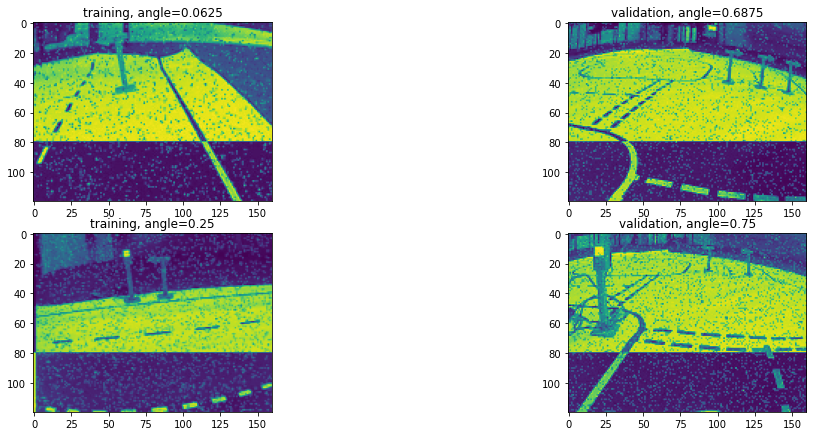

In [40]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

In [41]:
print(np.shape(X_train_batch[0]))

(120, 160)


In [48]:
# Stage 2 - load pretrained -freeze all layers and replace last layer
model_name = 'C:/Users/A/Desktop/ML2 Project/Saved Models/mixedmodel_fast.h5'
# model_name = "C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/fun_lane_navigation.h5"
model = load_model(model_name)
# print(model.summary())
for i in range(18):
    model.layers[i].trainable = False

x = model.layers[16].output
out = Dense(1, activation='sigmoid', name='angle')(x)
model = keras.Model(inputs=model.input, outputs=out)
optimizer = Adam(lr=1e-3) # lr is learning rate
model.compile(loss='mse', optimizer=optimizer)#, loss_weights = loss_weights )
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 160, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 58, 78, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 37, 32)        25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 33, 48)        38448     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 29, 48)        57648     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 14, 48)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 12, 64)         2771

In [49]:
# Stage 2 train
# saves the model weights after each epoch if the validation loss decreased
model_output_dir = 'C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'37_Stage_2.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=1,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=50, 
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'37_Stage_2_model.h5'))

C:\Users\A\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


300/300 [==============================] - 318s 1s/step - loss: 0.1559 - val_loss: 0.0446

Epoch 00001: val_loss improved from inf to 0.04461, saving model to C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021\37_Stage_2.h5


In [50]:
# Stage 3 - load pretrained -unfreeze 3+ layers and train with low lr
model_name = 'C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/37_Stage_2.h5'
# model_name = "C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/fun_lane_navigation.h5"
model = load_model(model_name)
# print(model.summary())
for i in range(3, 18):
    model.layers[i].trainable = True

optimizer = Adam(lr=1e-4) # lr is learning rate
model.compile(loss='mse', optimizer=optimizer)#, loss_weights = loss_weights )
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 160, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 58, 78, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 37, 32)        25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 33, 48)        38448     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 29, 48)        57648     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 14, 48)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 12, 64)         2771

In [51]:
# Stage 3 train
# saves the model weights after each epoch if the validation loss decreased
model_output_dir = 'C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'37_Stage_3.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=50, 
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'37_Stage_3_model.h5'))

Epoch 1/10
300/300 [==============================] - 339s 1s/step - loss: 0.0624 - val_loss: 0.0188

Epoch 00001: val_loss improved from inf to 0.01878, saving model to C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021\37_Stage_3.h5
Epoch 2/10
300/300 [==============================] - 356s 1s/step - loss: 0.0194 - val_loss: 0.0152

Epoch 00002: val_loss improved from 0.01878 to 0.01520, saving model to C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021\37_Stage_3.h5
Epoch 3/10
300/300 [==============================] - 352s 1s/step - loss: 0.0171 - val_loss: 0.0131

Epoch 00003: val_loss improved from 0.01520 to 0.01309, saving model to C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021\37_Stage_3.h5
Epoch 4/10
300/300 [==============================] - 351s 1s/step - loss: 0.0153 - val_loss: 0.0136

Epoch 00004: val_loss did not improve from 0.01309
Epoch 5/10
 26/300 [=>............................] - ETA: 5:04 - loss: 0.0145

KeyboardInterrupt: 

In [42]:
# Stage 4 - load pretrained -unfreeze all layers and train with low lr
model_name = '/Users/Kamyab/Documents/model37.h5'
# model_name = "C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/fun_lane_navigation.h5"
model = load_model(model_name)
# print(model.summary())
for i in range(18):
    model.layers[i].trainable = True

optimizer = Adam(lr=1e-4) # lr is learning rate
model.compile(loss='mse', optimizer=optimizer)#, loss_weights = loss_weights )
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 160, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 58, 78, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 37, 32)        25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 33, 48)        38448     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 29, 48)        57648     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 14, 48)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 12, 64)         2771

In [43]:
model_output_dir = '/Users/Kamyab/Documents/'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'arrow_check.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=100,
                              epochs=15,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=50, 
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'arrow_model.h5'))

/Users/kamyab/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
100/100 [==============================] - 150s 1s/step - loss: 0.0337 - val_loss: 0.0273

Epoch 00001: val_loss improved from inf to 0.02735, saving model to /Users/Kamyab/Documents/arrow_check.h5
Epoch 2/15
100/100 [==============================] - 94s 945ms/step - loss: 0.0261 - val_loss: 0.0177

Epoch 00002: val_loss improved from 0.02735 to 0.01769, saving model to /Users/Kamyab/Documents/arrow_check.h5
Epoch 3/15
100/100 [==============================] - 93s 936ms/step - loss: 0.0232 - val_loss: 0.0165

Epoch 00003: val_loss improved from 0.01769 to 0.01645, saving model to /Users/Kamyab/Documents/arrow_check.h5
Epoch 4/15
100/100 [==============================] - 93s 932ms/step - loss: 0.0198 - val_loss: 0.0176

Epoch 00004: val_loss did not improve from 0.01645
Epoch 5/15
100/100 [==============================] - 93s 927ms/step - loss: 0.0189 - val_loss: 0.0156

Epoch 00005: val_loss improved from 0.01645 to 0.01558, saving model to /Users/Kamyab/Documents/arrow_

In [56]:
# Stage 5 - load pretrained -unfreeze all layers and train with low lr
model_name = 'C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/37_Stage_4.h5'
# model_name = "C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/fun_lane_navigation.h5"
model = load_model(model_name)
# print(model.summary())
# for i in range(17):
#     model.layers[i].trainable = True

optimizer = Adam(lr=1e-5) # lr is learning rate
model.compile(loss='mse', optimizer=optimizer)#, loss_weights = loss_weights )
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 160, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 58, 78, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 37, 32)        25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 33, 48)        38448     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 29, 48)        57648     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 14, 48)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 12, 64)         2771

In [57]:
model_output_dir = 'C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'37_Stage_5.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=15,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=50, 
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'37_Stage_5_model.h5'))

Epoch 1/15
300/300 [==============================] - 471s 2s/step - loss: 0.0099 - val_loss: 0.0093

Epoch 00001: val_loss improved from inf to 0.00930, saving model to C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021\37_Stage_5.h5
Epoch 2/15
300/300 [==============================] - 486s 2s/step - loss: 0.0100 - val_loss: 0.0089

Epoch 00002: val_loss improved from 0.00930 to 0.00894, saving model to C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021\37_Stage_5.h5
Epoch 3/15
300/300 [==============================] - 485s 2s/step - loss: 0.0099 - val_loss: 0.0095

Epoch 00003: val_loss did not improve from 0.00894
Epoch 4/15
300/300 [==============================] - 571s 2s/step - loss: 0.0100 - val_loss: 0.0098

Epoch 00004: val_loss did not improve from 0.00894
Epoch 5/15
300/300 [==============================] - 617s 2s/step - loss: 0.0098 - val_loss: 0.0093

Epoch 00005: val_loss did not improve from 0.00894
Epoch 6/15
300/300 [=====================

In [52]:
model_output_dir = '/Users/Kamyab/Documents/'
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/arrow_model.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

mse       = 0.0083
r_squared = 90.42%



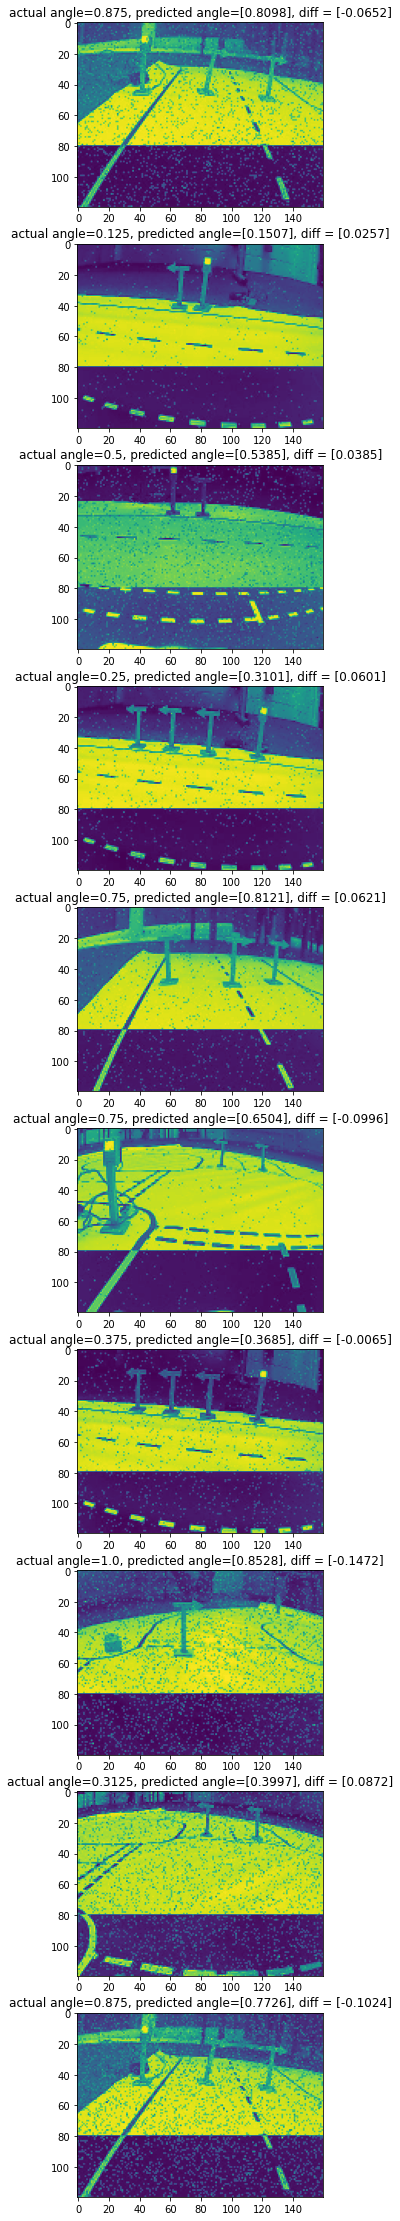

In [53]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 10
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={(y_pred[i])}, diff = {(y_pred[i])-y_test[i]}")
    

In [54]:
model = load_model(f'{model_output_dir}/arrow_model.h5')
path_file = '/Users/kamyab/Documents/UoN/MLiS_2/Project/Data/test_data/test_data/'
test_names = np.arange(1020) + 1
# with open(path_file + 'submission2.csv', mode='w', newline='') as submission:
#     writer = csv.writer(submission, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#     writer.writerow(['image_id', 'angle', 'speed'])
# for name in test_names[3]:     
img = cv2.imread(path_file + str(test_names[328]) + '.png')
#         print(img)
prediction = compute_steering_angle(model, img)
        
print(prediction)
plt.imshow(img)
   
 

NameError: name 'compute_steering_angle' is not defined

In [55]:
model_output_dir = '/Users/Kamyab/Documents/'
model = load_model(os.path.join(model_output_dir,'arrow_model.h5'))
       
def compute_steering_angle(self, frame):
    preprocessed = img_preprocess(frame)
    X = np.asarray([preprocessed])
    steering_angle = model.predict(X)
    return steering_angle

0.69340515


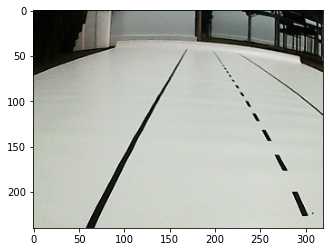

In [120]:
path_file = '/Users/kamyab/Documents/UoN/MLiS_2/Project/Data/test_data/test_data/'
img = cv2.imread(path_file + str(915)+'.png')
print(compute_steering_angle(model, img)[0][0])
plt.imshow(img)

In [49]:
path_file = 'C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/test_data/'

test_names = np.arange(1020) + 1
with open(path_file + 'submission2May.csv', mode='w', newline='') as submission:
    writer = csv.writer(submission, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['image_id', 'angle', 'speed'])
 
#     fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
    for name in test_names:     
        img = cv2.imread(path_file + str(name) + '.png')
        prediction = compute_steering_angle(model, img)
        writer.writerow([name, prediction[0][0]])

 